# Problemas de detecção (binária)

Imagine duas situações:

1. Quero que o mecanismo de proteção do meu cliente tenha especificidade (precisão) máxima, isto é, não gere falsos alarmes (FP);
2. Tenho que proteger um sistema crítico (infraestrutura, controle) e preciso de sensibilidade (recall) máxima, isto é, que o mecanismo de proteção não deixe passar nada (FN)...

**Como ajustar o seu modelo?**

Os códigos de ajuste e textos explicativos das Seçoes "Estratégia 1" e "Estratégia 2" foram baseados em (e traduzidos de) 
https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

dfgw_all = pd.read_csv('https://raw.githubusercontent.com/fabriciojoc/brazilian-malware-dataset/master/goodware-malware/goodware.csv') # dataset amostras benignas
dfmw1 = pd.read_csv('https://raw.githubusercontent.com/fabriciojoc/brazilian-malware-dataset/master/goodware-malware/malware-by-day/2014-05-19.csv') # subset amostras maliciosas
dfmw2 = pd.read_csv('https://raw.githubusercontent.com/fabriciojoc/brazilian-malware-dataset/master/goodware-malware/malware-by-day/2014-05-20.csv') # subset amostras maliciosas
dfmw3 = pd.read_csv('https://raw.githubusercontent.com/fabriciojoc/brazilian-malware-dataset/master/goodware-malware/malware-by-day/2015-05-19.csv') # subset amostras maliciosas

Criar coluna de rótulos de acordo com o tamanho dos datasets e a adiciono...

In [2]:
gwlabel = ['benigno'] * len(dfgw_all)
dfgw_all['label'] = gwlabel

In [3]:
dfmw = pd.concat([dfmw1, dfmw2, dfmw3])
dfmwlabel = ['malicioso'] * len(dfmw)
dfmw['label'] = dfmwlabel
dfmw

,BaseOfCode,BaseOfData,Characteristics,DllCharacteristics,Entropy,FileAlignment,FileType,FormatedTimeDateStamp,Fuzzy,Identify,...,SHA1,Size,SizeOfCode,SizeOfHeaders,SizeOfImage,SizeOfInitializedData,SizeOfOptionalHeader,SizeOfUninitializedData,TimeDateStamp,label
0,4096,712704,41358,0,7.965493,512,"PE32 executable (DLL) (GUI) Intel 80386, for M...",2014-05-18 17:58:08,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...",[['ASProtect V2.X DLL -> Alexey Solodovnikov']...,...,7030f9f721d366b3fac528a6cb2983ee6fd2bdfb,631808,706560,1024,1208320,135680,224,0,1400446688,malicioso
1,4096,888832,33166,0,7.138965,512,"PE32 executable (GUI) Intel 80386, for MS Windows",1992-06-19 19:22:17,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...","[['Borland Delphi 3.0 (???)'], ['Borland Delph...",...,3763e1dd875810f0bf39bc6d8d128cd765778e10,4249088,882688,1024,4276224,3365376,224,0,708992537,malicioso
2,4096,577536,290,32832,7.805395,512,"PE32 executable (GUI) Intel 80386, for MS Windows",2014-05-19 16:37:18,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...","[['Microsoft Visual C++ 8'], ['VC8 -> Microsof...",...,1ca7988d3d0aadf8f976944db0ebccd876abc5b5,3846144,573440,1024,3870720,3271680,224,0,1400528238,malicioso
3,4096,405504,41358,1,6.577088,512,"PE32 executable (DLL) (GUI) Intel 80386, for M...",1992-06-19 19:22:17,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...","[['Borland Delphi 3.0 (???)'], ['Borland Delph...",...,c9dbd336a6c26280f6c84b8ec0d05c5345b578f8,471040,397824,1024,491520,72192,224,0,708992537,malicioso
4,458752,716800,41358,1,7.897976,512,"PE32 executable (DLL) (GUI) Intel 80386, for M...",1992-06-19 19:22:17,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...",[['ACProtect 1.3x - 1.4x DLL -> Risco Software...,...,2ad786933c36031e9d826a52d6563accda43e136,262144,258048,4096,724992,8192,224,454656,708992537,malicioso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,4096,3907584,33166,0,6.822824,512,"PE32 executable (GUI) Intel 80386, for MS Windows",2015-05-18 13:54:40,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...","[['Borland Delphi 3.0 (???)'], ['Borland Delph...",...,450f2abb9f3abd6c7c7260668d23d31903ed8c30,5241856,3901952,1024,5541888,1587200,224,0,1431968080,malicioso
31,4096,520192,8462,0,5.857582,4096,"PE32 executable (DLL) (GUI) Intel 80386, for M...",2015-05-13 09:34:32,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...",[['Microsoft Visual Basic v6.0 DLL']],...,3892744c00a206e4cf98fac475c14fd275a5c0e8,573440,516096,4096,581632,61440,224,0,1431520472,malicioso
32,4096,24576,271,0,5.834434,4096,"PE32 executable (GUI) Intel 80386, for MS Windows",2014-02-16 18:54:49,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...",NaN,...,49e9ddc232c79b44641f1c661d241e2da86db558,61440,20480,4096,61440,36864,224,0,1392587689,malicioso
33,4096,2240512,33166,0,6.586521,512,"PE32 executable (GUI) Intel 80386, for MS Windows",2015-05-19 09:01:16,"(0, 'ssdeep,1.1--blocksize:hash:hash,filename\...","[['Borland Delphi 3.0 (???)'], ['Borland Delph...",...,4984cdf35f336b8f71bea4b492ea35bd9bbbddd0,2563584,2232832,1024,2617344,329728,224,0,1432036876,malicioso


Reamostragem do dataframe benigno e merge de ambos para criação do dataset

In [4]:
from sklearn.utils import resample
dfgw = resample(dfgw_all, n_samples=10*len(dfmw))
dfapps = pd.concat([dfgw,dfmw])
#dfapps.drop(columns=['FileType','Fuzzy'])
dfapps = dfapps.reset_index()
dfapps = dfapps[['BaseOfCode', 'BaseOfData', 'Characteristics', 'DllCharacteristics', 'Entropy', 'FileAlignment', 'ImageBase', 'NumberOfRvaAndSizes', 'NumberOfSections', 'NumberOfSymbols', 'Size', 'SizeOfCode', 'SizeOfHeaders', 'SizeOfImage', 'SizeOfInitializedData', 'label']]
dfapps

,BaseOfCode,BaseOfData,Characteristics,DllCharacteristics,Entropy,FileAlignment,ImageBase,NumberOfRvaAndSizes,NumberOfSections,NumberOfSymbols,Size,SizeOfCode,SizeOfHeaders,SizeOfImage,SizeOfInitializedData,label
0,4096,32768,259,33792,7.999943,512,4194304,16,5,0,41380664,25600,1024,1871872,431104,benigno
1,4096,12288,8450,16704,4.955738,512,268435456,16,5,0,11264,5632,1024,28672,5120,benigno
2,4096,32768,258,34112,7.997133,512,4194304,16,6,0,36250840,28672,1024,1454080,445952,benigno
3,4096,1622016,33166,0,7.875283,512,4194304,16,10,0,14340384,1615360,1024,14585856,12710912,benigno
4,8192,40960,8450,34112,4.914595,512,4194304,16,3,0,29184,26624,512,57344,2048,benigno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,4096,3907584,33166,0,6.822824,512,4194304,16,10,0,5241856,3901952,1024,5541888,1587200,malicioso
1492,4096,520192,8462,0,5.857582,4096,285212672,16,4,0,573440,516096,4096,581632,61440,malicioso
1493,4096,24576,271,0,5.834434,4096,4194304,16,4,0,61440,20480,4096,61440,36864,malicioso
1494,4096,2240512,33166,0,6.586521,512,4194304,16,11,0,2563584,2232832,1024,2617344,329728,malicioso


Transformo a coluna de rótulo em inteiro, benigno sendo o "negativo" (classe maior, não quero detectar)

In [5]:
lb = LabelBinarizer()
dfapps['label'] = lb.fit_transform(dfapps['label'].values)
targets = dfapps['label']

dfapps.drop(['label'], axis=1, inplace=True)
dfapps

,BaseOfCode,BaseOfData,Characteristics,DllCharacteristics,Entropy,FileAlignment,ImageBase,NumberOfRvaAndSizes,NumberOfSections,NumberOfSymbols,Size,SizeOfCode,SizeOfHeaders,SizeOfImage,SizeOfInitializedData
0,4096,32768,259,33792,7.999943,512,4194304,16,5,0,41380664,25600,1024,1871872,431104
1,4096,12288,8450,16704,4.955738,512,268435456,16,5,0,11264,5632,1024,28672,5120
2,4096,32768,258,34112,7.997133,512,4194304,16,6,0,36250840,28672,1024,1454080,445952
3,4096,1622016,33166,0,7.875283,512,4194304,16,10,0,14340384,1615360,1024,14585856,12710912
4,8192,40960,8450,34112,4.914595,512,4194304,16,3,0,29184,26624,512,57344,2048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,4096,3907584,33166,0,6.822824,512,4194304,16,10,0,5241856,3901952,1024,5541888,1587200
1492,4096,520192,8462,0,5.857582,4096,285212672,16,4,0,573440,516096,4096,581632,61440
1493,4096,24576,271,0,5.834434,4096,4194304,16,4,0,61440,20480,4096,61440,36864
1494,4096,2240512,33166,0,6.586521,512,4194304,16,11,0,2563584,2232832,1024,2617344,329728


Separo o dataset em treinamento e teste, com distribuição equivalente das classes (stratify)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dfapps, targets, stratify=targets)

In [7]:
# Mostra a distribuição
print('\n=========================\nDistribuição de Classes (y_train)\n=========================\n')
print(y_train.value_counts(normalize=True))
print()
print(y_train.value_counts())
print('\n=========================\nDistribuição de Classes (y_test)\n=========================\n')
print(y_test.value_counts(normalize=True))
print()
print(y_test.value_counts())


Distribuição de Classes (y_train)

0    0.909091
1    0.090909
Name: label, dtype: float64

0    1020
1     102
Name: label, dtype: int64

Distribuição de Classes (y_test)

0    0.909091
1    0.090909
Name: label, dtype: float64

0    340
1     34
Name: label, dtype: int64


# ESTRATÉGIA 1

**Otimizar para sensibilidade usando GridSearchCV com argumento de pontuação**

Primeiro construa um classificador genérico e estabeleça uma grade de parâmetros (para o GridSearchCV). O dicionário de pontuadores (*scorers*) pode ser usado como argumento de pontuação no GridSearchCV.

In [8]:
# Teste com random forest
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

A função abaixo utiliza a 'GridSearchCV' para ajustar vários classificadores de acordo com a combinação de parâmetros em 'param_grid'. Os scores dos scorers são salvos e o melhor modelo (conforme pontuado pelo argumento 'refit') serão selecionados e "reajustados" para os dados completos do treinamento para utilização posterior. Provê também as previsões relacionadas ao X_test e imprime a matriz de confusão para mostrar a eficácia.

O objetivo desta função é permitir rapidamente o reuso de código para encontrar o melhor classificador de acordo com o tipo de métrica de pontuação escolhida. Primeiro, tenta-se com 'precision_score', que deve limitar o número de falsos-positivos (não é bom para o objetivo de máxima sensibilidade, mas permite mostrar a diferença entre um classificador otimizado para taxa de precisão e um otimizado para taxa de recall).

In [9]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

Execução do Random Forest com os parâmetros definidos, otimizando pela precisão

In [10]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1017, in __call__
    self.retrieve

Best params for precision_score
{'max_depth': 3, 'max_features': 3, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       339         1
pos        12        22


Os valores dos *scores* de **precisão**, **recall** e **acurácia** para cada combinação de parâmetros em 'param_grid' são armazenados em cv_results_.

O DataFrame Pandas auxilia na visualização das pontuações e dos parâmetros para cada iteração do classificador. Desta forma, mostra-se que embora a acurácia possa ser relativamente consistente entre os classificadores, há o *trade-off* entre **precisão** e **recall**. 

A ordenação pela precisão deve mostrar o melhor modelo de pontuação como primeiro registro. Verifique olhando os parâmetros do primeiro registro e comparando-os com os resultados gerados no grid_search.best_params_ acima.

In [11]:
results = pd.DataFrame(grid_search_clf.cv_results_)
#print(results[results.isnull().any(axis=1)])
results = results.dropna()
#results
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
2,0.933,0.595,0.960,3,3,5,100
76,0.932,0.811,0.978,25,3,10,100
14,0.931,0.565,0.957,3,10,5,100
51,0.930,0.851,0.980,15,3,5,300
16,0.929,0.545,0.955,3,10,10,100


O classificador gerado foi otimizado para **precisão**. Para efeitos de comparação e de mostrar como o 'GridSearchCV' seleciona o melhor classificador, a chamada de função abaixo retorna um classificador otimizado para o **recall**. O grid pode ser similar ao acima, com a diferença que o classificador com maior recall irá ser reajustado. Esta é a métrica mais desejável para problemas onde o importante é ter menor taxa de **falso-negativo** na matriz de confusão.

In [12]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1017, in __call__
    self.retrieve

Best params for recall_score
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       337         3
pos         6        28


In [13]:
results2 = pd.DataFrame(grid_search_clf.cv_results_)
#print(results2[results2.isnull().any(axis=1)])
results2 = results2.dropna()
#results
results2 = results2.sort_values(by='mean_test_recall_score', ascending=False)
results2[['mean_test_recall_score', 'mean_test_precision_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_recall_score,mean_test_precision_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
61,0.862,0.888,0.977,15,10,3,300
85,0.862,0.899,0.978,25,10,3,300
78,0.861,0.899,0.978,25,5,3,100
57,0.861,0.914,0.979,15,5,5,300
72,0.861,0.914,0.979,25,3,3,100


# ESTRATÉGIA 2

As Curvas P/R e ROC são ferramentas úteis para visualizar o equilíbrio sensibilidade-especificidade de um classificador. Elas auxiliam o cientista de dados a definir o limiar de decisão do modelo para maximizar a precisão ou o recall. 

*A chave para aprender a fazer o ajuste fino de modelos no scikit-learn é entender os métodos .predict_proba() e .decision_function(), os quais retornam a probabilidade (número bruto) de uma amostra pertencer a uma classe. A probabilidade retornada é diferente da atribuição absoluta das classes (predição) retornada plea chamada do método .predict().*

Para fazer esse método generalizável para todos os classificadores, saiba que alguns deles (ex.: Random Forest) usam .predict_proba(), enquanto outros (ex.: SVC) usam a .decision_function(). O limiar padrão para o classificador Random Forest é 0.5, então use-o como ponto de partida. Para tanto, comece criando um vetor das probabilidades de cada classe chamado *y_scores*.

In [14]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

/home/abner_bissolli/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Gero a curva P/R (*Precision/Recall*) para o classificador

In [15]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

Abaixo, *adjusted_classes* é uma função simples para retornar uma versão modificada de *y_scores* que foi calculada mais acima, porém os rótulos de classe serão atribuídos de acordo com o limiar de probabilidade (*threshold*) **t**. A outra função, *precision_recall_threshold*, gera o gráfico da precisão e do recall de acordo com o valor de limiar dado (*threshold* t).

In [16]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

Re-execute a função *precision_recall_threshold* por várias iterações, modificando **t** a cada vez para ajustar o limiar até o resultado gerado conter 0 Falsos-Negativos.

     pred_neg  pred_pos
neg       340         0
pos        11        23


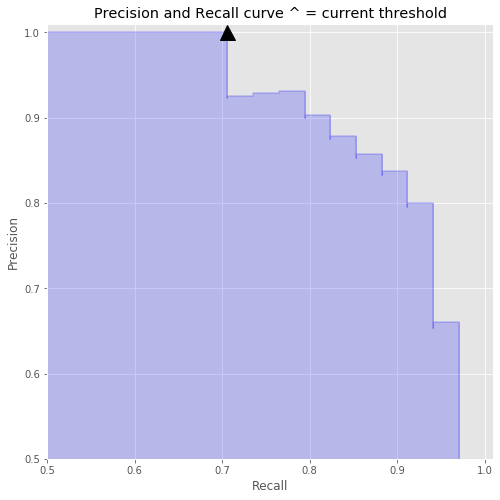

In [17]:
precision_recall_threshold(p, r, thresholds, 0.9)

     pred_neg  pred_pos
neg       338         2
pos         8        26


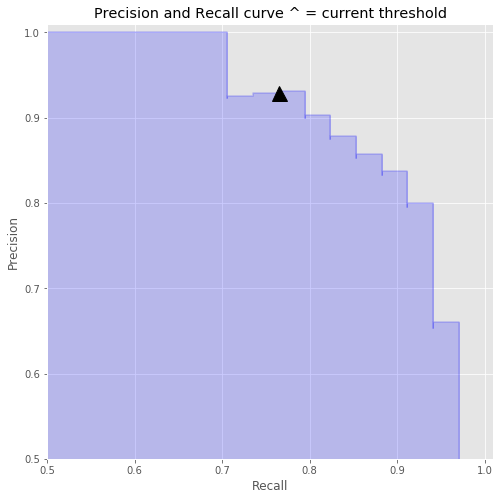

In [18]:
precision_recall_threshold(p, r, thresholds, 0.7)

 t =  0.0 

     pred_neg  pred_pos
neg         0       340
pos         0        34

 t =  0.05 

     pred_neg  pred_pos
neg       302        38
pos         1        33

 t =  0.1 

     pred_neg  pred_pos
neg       316        24
pos         1        33

 t =  0.15000000000000002 

     pred_neg  pred_pos
neg       323        17
pos         1        33

 t =  0.2 

     pred_neg  pred_pos
neg       328        12
pos         2        32

 t =  0.25 

     pred_neg  pred_pos
neg       330        10
pos         2        32

 t =  0.30000000000000004 

     pred_neg  pred_pos
neg       332         8
pos         3        31

 t =  0.35000000000000003 

     pred_neg  pred_pos
neg       333         7
pos         3        31

 t =  0.4 

     pred_neg  pred_pos
neg       335         5
pos         5        29

 t =  0.45 

     pred_neg  pred_pos
neg       335         5
pos         5        29

 t =  0.5 

     pred_neg  pred_pos
neg       337         3
pos         6        28

 t =  0.55 

 

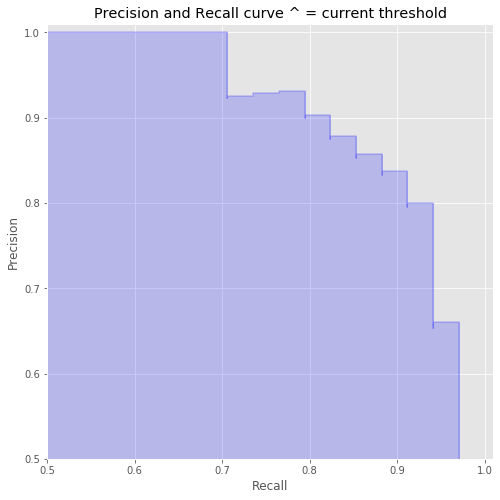

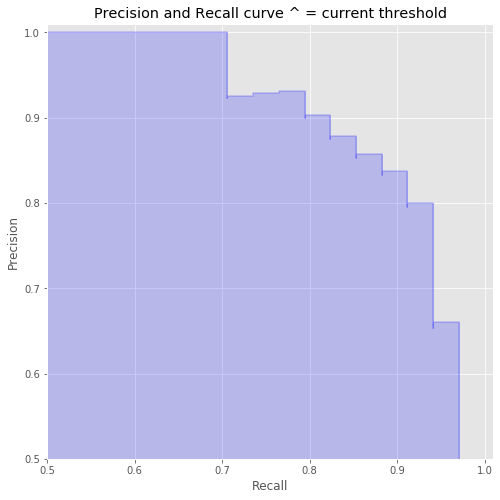

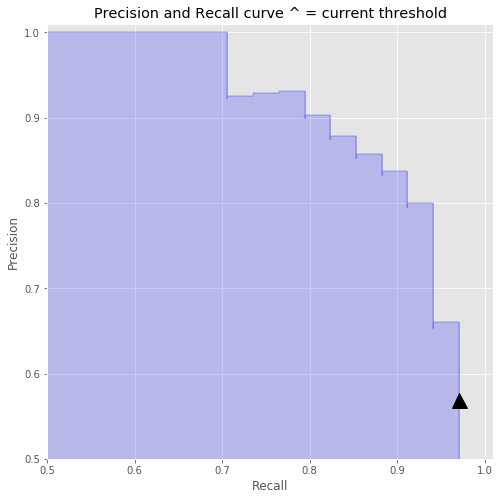

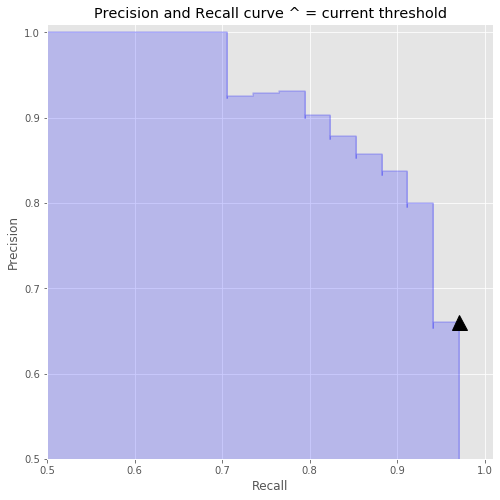

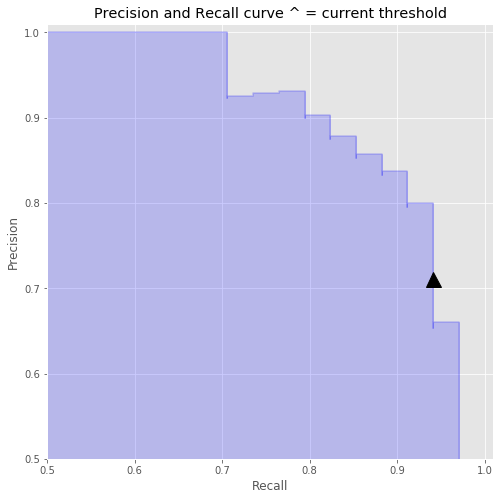

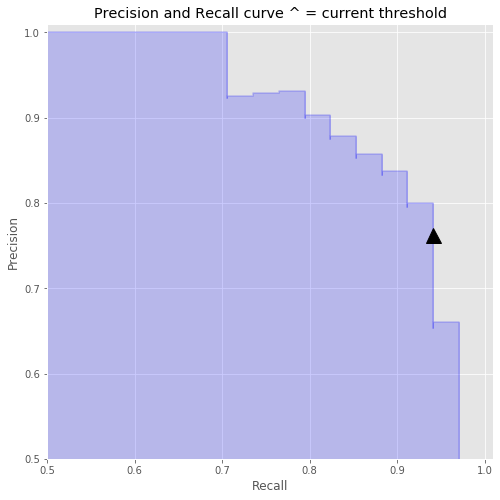

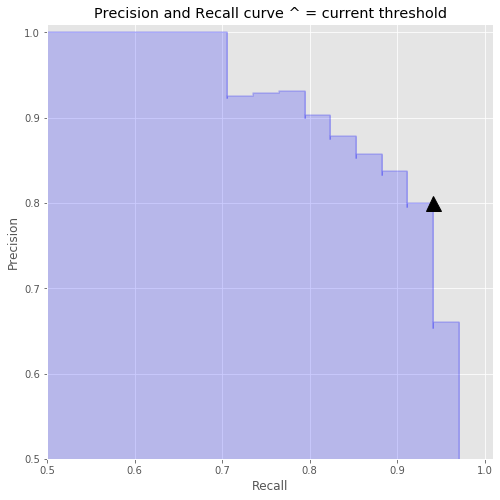

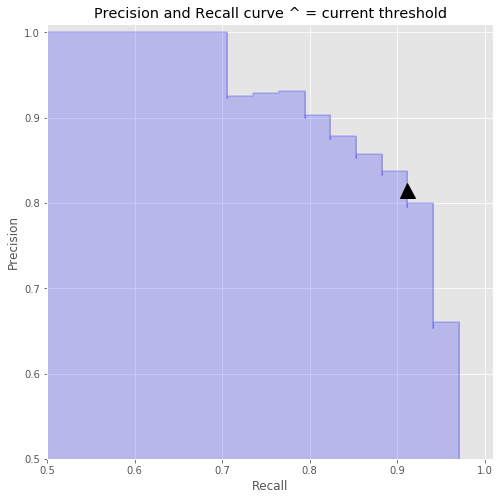

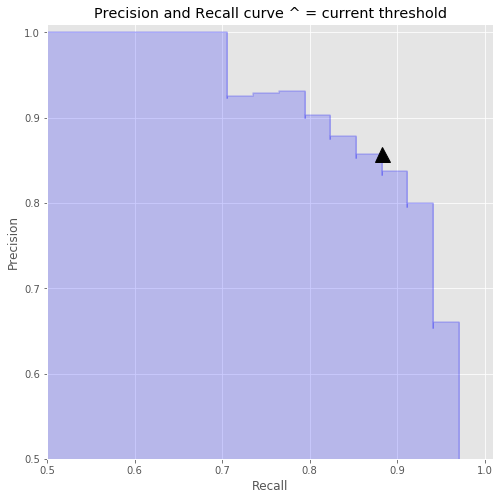

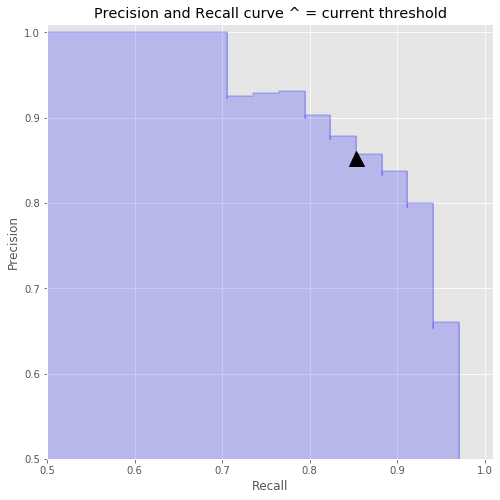

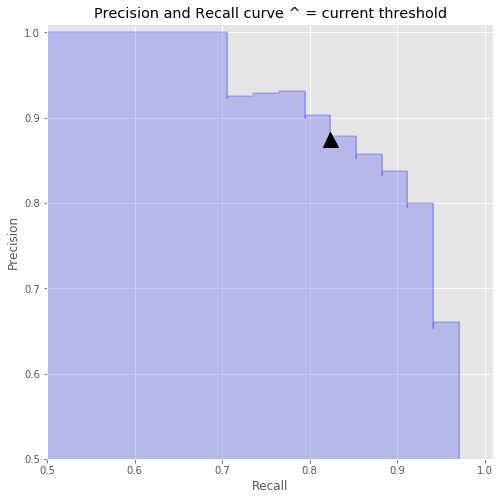

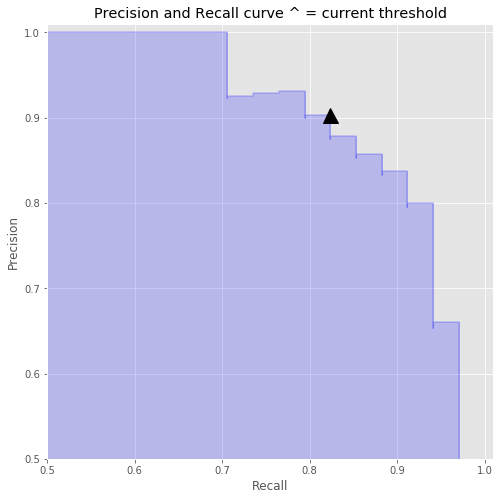

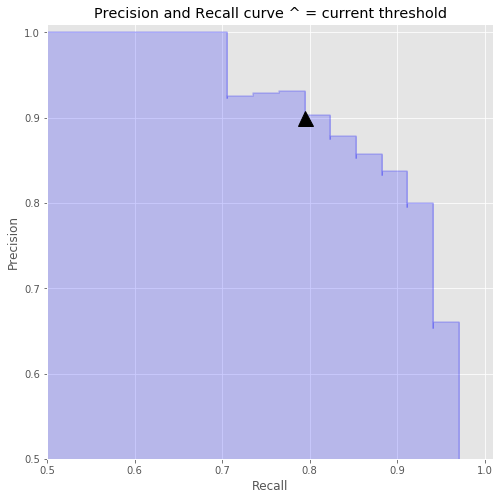

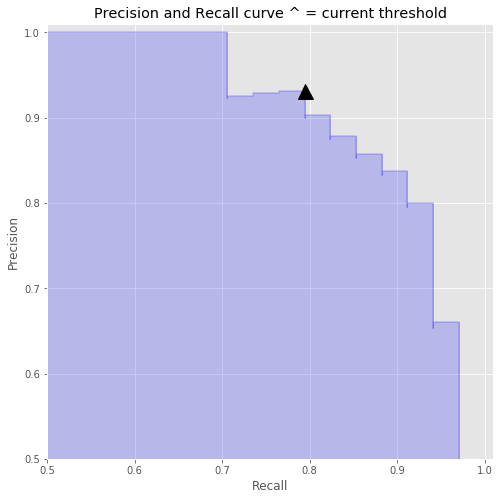

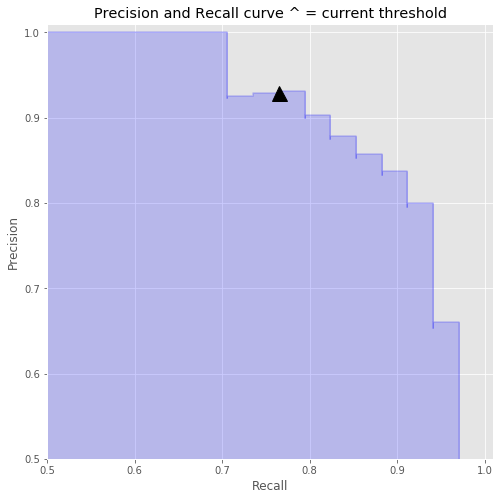

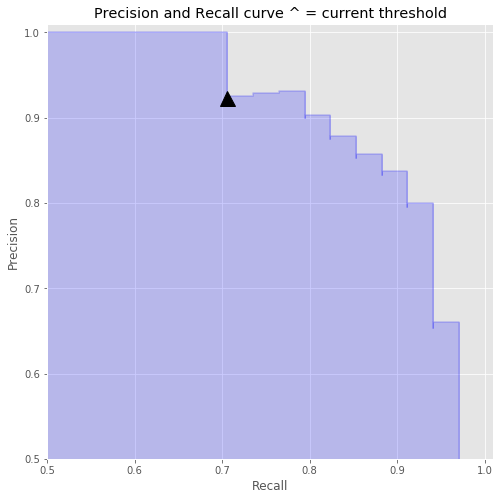

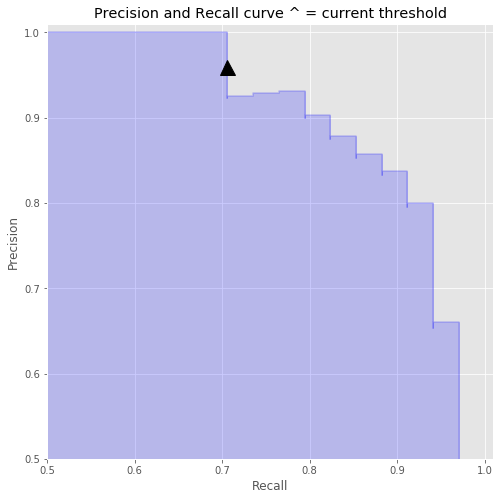

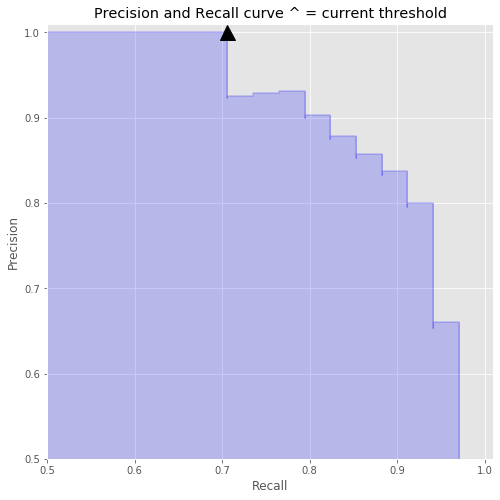

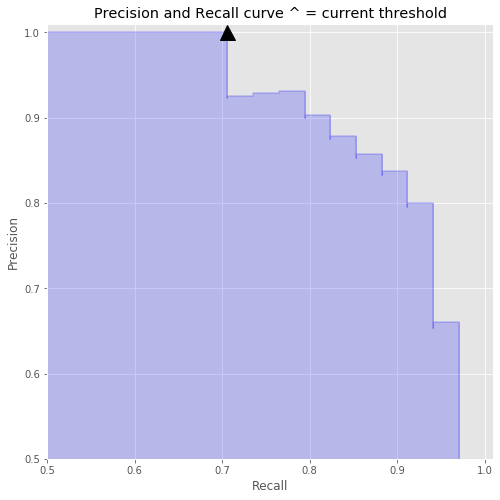

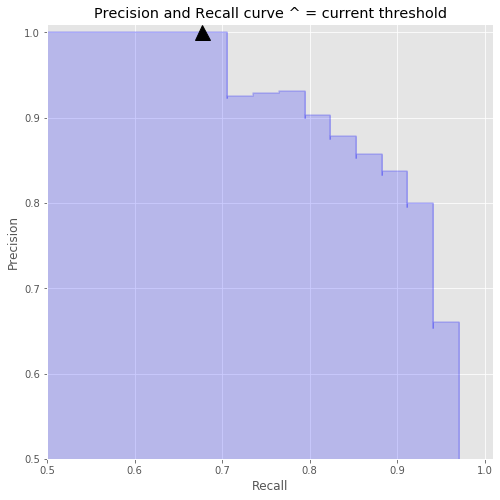

In [19]:
for t in np.arange(0,1,.05):
  print("=================\n t = ", t, "\n=================\n")
  precision_recall_threshold(p, r, thresholds, t)
  print()

     pred_neg  pred_pos
neg       306        34
pos         1        33


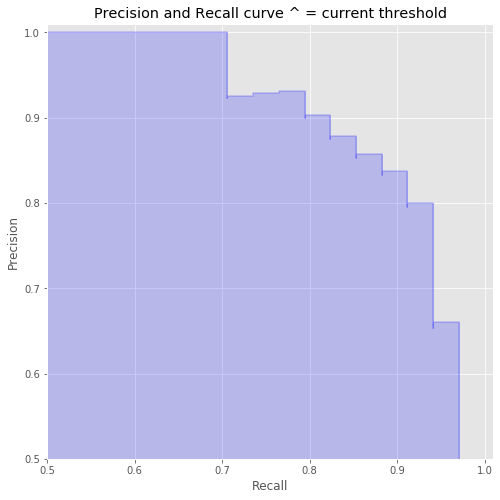

In [20]:
precision_recall_threshold(p, r, thresholds, 0.06)

Uma outra maneira de visualizar o *trade-off* entre precisão e recall é plotar ambas as taxas como uma função do limiar de decisão.

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

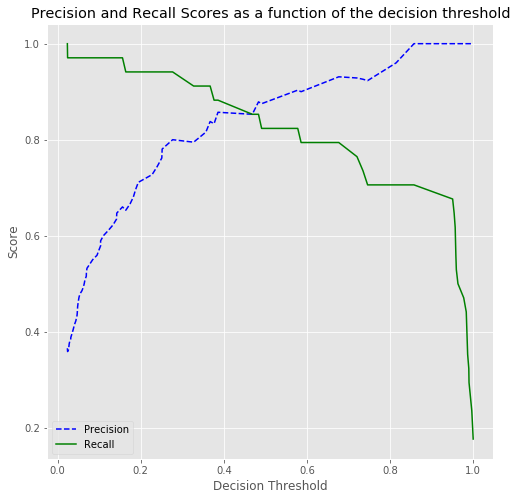

In [22]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

Finalmente, a curva ROC mostra que, para se alcançar um recall (sensibilidade) de 1.0, o usuário do modelo deve selecionar um ponto de operação que permita algum falso positivo (isto é, TFP > 0.0).

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9906574394463667


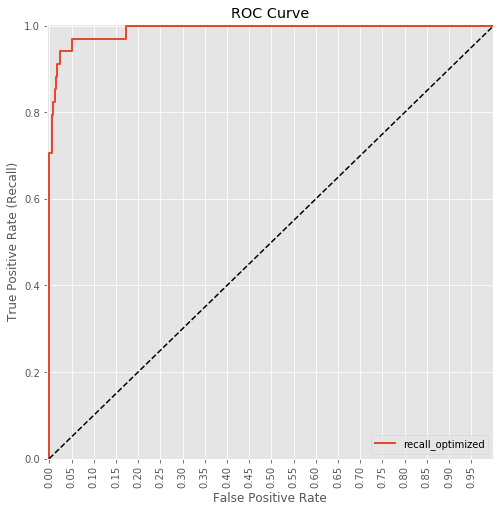

In [24]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')